In [112]:
import numpy as np
import pandas as pd
import os
import psutil

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = [16, 11]
plt.rcParams["figure.autolayout"] = True

# DEMO Sprint 2

The following script will showcase the naive model and the first implementation of our own algorithms. For ease of use, it will run on only 10% of the dataset.

## Load data
Here we load the data, and make sure that the entire data set is contained in one dataframe, for manual splitting. This manual splitting will later be done so that we can control the that all events used for training, will take place before the test set, avoiding the future data problem. The data will be sorted according to its time values.

In [113]:
# helper functions

def data_split(df):
    """returns 10% of the data"""
    return df[: int((len(df)/10))]


def EventTime(data):
    
    for i in list(data["case concept:name"].unique()):
        data.loc[data["case concept:name"] == i, "nextTIME"] = data.loc[data["case concept:name"] == i, 
                                                                "event time:timestamp"].shift(-1)
    return data


def next_event(data, lst, case, nxt, name):
    """function to add the next event of a trace"""
    for i in lst:
        data.loc[data[case] == i, nxt] = data.loc[data[case] == i, name].shift(-1)
    return data

In [114]:
path = r"D:/University/Year 2/Q3/DBL/Data/BPI Challenge 2012/"
df_train = pd.read_csv(f'{path}BPI_Challenge_2012-training.csv')
df_test = pd.read_csv(f'{path}BPI_Challenge_2012-test.csv')


df_data = pd.concat([df_train, df_test])

In [115]:
# split the data to 10% of total data, to help with runtime for demo
df_data = data_split(df_data)

In [116]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
unixTransform = lambda x: time.mktime(x.timetuple())
secondsTransform = lambda x: x.total_seconds()

df_data["timestamp"] = df_data["event time:timestamp"].copy()
df_data["event time:timestamp"] = pd.to_datetime(df_data["event time:timestamp"], dayfirst=True)

In [117]:
df_data.sort_values(by=['event time:timestamp'], inplace=True)
df_data.columns = df_data.columns.str.strip()

In [118]:
df_data.head()

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,timestamp
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,A_SUBMITTED,COMPLETE,2011-10-01 00:38:44.546,01-10-2011 00:38:44.546
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,A_PARTLYSUBMITTED,COMPLETE,2011-10-01 00:38:44.880,01-10-2011 00:38:44.880
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,A_PREACCEPTED,COMPLETE,2011-10-01 00:39:37.906,01-10-2011 00:39:37.906
3,3,173688,2011-10-01T00:38:44.546+02:00,20000,W_Completeren aanvraag,SCHEDULE,2011-10-01 00:39:38.875,01-10-2011 00:39:38.875
4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,A_SUBMITTED,COMPLETE,2011-10-01 08:08:58.256,01-10-2011 08:08:58.256


In [119]:
df_naive = df_data.copy()

## Preprocessing and feature engineering

In [120]:
# assign long column names to variables for easier use
cases = "case concept:name"
reg_date = "case REG_DATE"
amount_req = "case AMOUNT_REQ"
event_name = "event concept:name"
lifecycle = "event lifecycle:transition"
tmstmp = "event time:timestamp"
nxt_event = "next event"
dtime = "delta time"

In [121]:
print(f'{df_data[lifecycle].unique()[0]} happens {len(df_data[df_data[lifecycle] == df_data[lifecycle].unique()[0]])}')
print(f'{df_data[lifecycle].unique()[1]} happens {len(df_data[df_data[lifecycle] == df_data[lifecycle].unique()[1]])}')
print(f'{df_data[lifecycle].unique()[2]} happens {len(df_data[df_data[lifecycle] == df_data[lifecycle].unique()[2]])}')

COMPLETE happens 16957
SCHEDULE happens 2983
START happens 6280


In [122]:
df_complete = df_data[df_data[lifecycle] == df_data[lifecycle].unique()[0]].copy()

In [123]:
# now drop unused columns
df_complete.drop(["eventID", reg_date], axis=1, inplace=True)

In [124]:
print(f'The number of unique cases/traces in the dataset is {len(df_complete[cases].unique())}')

The number of unique cases/traces in the dataset is 1802


In [125]:
lst_events = df_complete[cases].unique().tolist()

In [126]:
# add next events per trace
next_event(df_complete, lst_events, cases, nxt_event, event_name);

In [127]:
# add time till next event per trace
EventTime(df_complete);

In [128]:
# for this sprint, drop all columns with nan values, as they influence results
df_complete.dropna(inplace=True)

In [129]:
df_processed = df_complete.drop([lifecycle], axis=1).copy()
df_processed.head()

,case concept:name,case AMOUNT_REQ,event concept:name,event time:timestamp,timestamp,next event,nextTIME
0,173688,20000,A_SUBMITTED,2011-10-01 00:38:44.546,01-10-2011 00:38:44.546,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880
1,173688,20000,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880,01-10-2011 00:38:44.880,A_PREACCEPTED,2011-10-01 00:39:37.906
2,173688,20000,A_PREACCEPTED,2011-10-01 00:39:37.906,01-10-2011 00:39:37.906,A_ACCEPTED,2011-10-01 11:42:43.308
4,173691,5000,A_SUBMITTED,2011-10-01 08:08:58.256,01-10-2011 08:08:58.256,A_PARTLYSUBMITTED,2011-10-01 08:09:02.195
5,173691,5000,A_PARTLYSUBMITTED,2011-10-01 08:09:02.195,01-10-2011 08:09:02.195,A_PREACCEPTED,2011-10-01 08:09:56.648


## Models

The naive model will be evaluated first

In [130]:
def simplePred(df,lst, cEvnt, cNw, cPrd):
    '''loops through the list of events and adds them to the df'''
    i = 0
    while i < len(lst):
        df.loc[df[cEvnt] == lst[i], cPrd] = df[df[cEvnt] == lst[i]][cNw].mode()[0]
        i += 1
    RAM = ('RAM memory % used:', psutil.virtual_memory()[2])
    CPU = ('CPU % used:', psutil.cpu_percent())
    return df, RAM, CPU

def simpleAccuracy(df, cReal, cPrd):
    '''computes a simple accuracy score'''
    return len(df[df[cReal] == df[cPred]]) / len(df)

In [131]:
cEvent = 'event concept:name'
cNew = 'next event'
cPred = 'predicted next event'

df_naive[cNew] = df_naive[cEvent].shift(-1)
df_naive[cPred] = np.nan
lstEvents = df_naive[cEvent].unique().tolist()

In [132]:
%%time
simplePred(df_naive, lstEvents, cEvent, cNew, cPred);

Wall time: 105 ms


(             eventID  case concept:name                  case REG_DATE  \
 0                  0             173688  2011-10-01T00:38:44.546+02:00   
 1                  1             173688  2011-10-01T00:38:44.546+02:00   
 2                  2             173688  2011-10-01T00:38:44.546+02:00   
 3                  3             173688  2011-10-01T00:38:44.546+02:00   
 4         4294967296             173691  2011-10-01T08:08:58.256+02:00   
 ...              ...                ...                            ...   
 26215  7486127996934             179188  2011-10-23T12:14:03.577+02:00   
 26216  5355824218132             177609  2011-10-17T18:38:21.448+02:00   
 26217  5355824218133             177609  2011-10-17T18:38:21.448+02:00   
 26218  5355824218134             177609  2011-10-17T18:38:21.448+02:00   
 26219  7580617277446             179254  2011-10-23T16:47:31.624+02:00   
 
        case AMOUNT_REQ      event concept:name event lifecycle:transition  \
 0                20

In [133]:
simpleAccuracy(df_naive, cNew, cPred)

0.4820747520976354

In [134]:
def EventTime(data):
    memory = {} # Stores active events, key=event, value=index of start
    for i, j in data[["event concept:name"]].iterrows():
        
        if j[0] not in memory.keys() and data.loc[i]["event lifecycle:transition"].lower() == "start":
            memory[j[0]] = i
        
        elif j[0] in memory.keys():
            time = pd.to_datetime(data.loc[i]["event time:timestamp"], dayfirst=True) - pd.to_datetime(data.loc[memory[j[0]]]["event time:timestamp"], dayfirst=True)           # print(time)
            data.loc[i,"Completion Time"] = time.total_seconds()
            del memory[j[0]] # Removes the completed event from active event dictionary(memory)
    
    return data # Returns a new dataframe with event completion time. Can be improved.

def AverageTime(df_train):
    """
    1. Computes the event completion time for events that don't have a "start" by taking the 
       difference between said event's completion time and the previous (i-1) event time. Still have 
       to determine how correct this is, as several events can run in parallel.
    2. Sets new index on df and computes the remaining event times (for events that have a start and completion time)
       by running the EventTime function case by case. Can be improved.
    3. Returns average completion time per event.
    
    """
    df_train["Completion Time"] = 0
    df_train.replace(0,np.NaN, inplace=True)
    for i in range(1, df_train['Completion Time'].shape[0]-1): # 1
        if pd.isnull(df_train['Completion Time'][i]):
            if df_train['event lifecycle:transition'][i].lower() == 'complete':
                time = pd.to_datetime(df_train["event time:timestamp"][i], dayfirst=True) - pd.to_datetime(df_train["event time:timestamp"][i-1], dayfirst=True)          
                df_train['Completion Time'][i] = time.total_seconds()
    
    df_train.set_index(["case concept:name", "eventID"], inplace=True) # 2
    
    for idx, new_df in df_train.groupby(level=0): # Adds event completion time, case by case.
        df_train.loc[idx] = EventTime(new_df)
        
    Average_time = df_train.groupby(['event concept:name'])[['Completion Time']].mean() # 3
    return Average_time

#Average time in seconds
def AddAverageTime(data):
    data['Average time till next event'] = 0
    avr_time = AverageTime(data)
    avr_time.reset_index(inplace=True)
    data.reset_index(inplace=True)
    for i in range(0, data['Completion Time'].shape[0]):
        abc = data['event concept:name'][i]
        time = avr_time.loc[avr_time['event concept:name'] == abc, 'Completion Time']
        time_list = list(time)
        data['Average time till next event'][i] = time_list[0]
    RAM = ('RAM memory % used:', psutil.virtual_memory()[2])
    CPU = ('CPU % used:', psutil.cpu_percent())
    return data, RAM, CPU

In [135]:
%%time
AddAverageTime(df_naive)

C:\Users\Jarl\AppData\Local\Temp/ipykernel_16152/1945124935.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Completion Time'][i] = time.total_seconds()
C:\Users\Jarl\AppData\Local\Temp/ipykernel_16152/1945124935.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Average time till next event'][i] = time_list[0]


Wall time: 40 s


(       case concept:name           eventID                  case REG_DATE  \
 0                 173688               NaN  2011-10-01T00:38:44.546+02:00   
 1                 173688             1.000  2011-10-01T00:38:44.546+02:00   
 2                 173688             2.000  2011-10-01T00:38:44.546+02:00   
 3                 173688             3.000  2011-10-01T00:38:44.546+02:00   
 4                 173691    4294967296.000  2011-10-01T08:08:58.256+02:00   
 ...                  ...               ...                            ...   
 26215             179188 7486127996934.000  2011-10-23T12:14:03.577+02:00   
 26216             177609 5355824218132.000  2011-10-17T18:38:21.448+02:00   
 26217             177609 5355824218133.000  2011-10-17T18:38:21.448+02:00   
 26218             177609 5355824218134.000  2011-10-17T18:38:21.448+02:00   
 26219             179254 7580617277446.000  2011-10-23T16:47:31.624+02:00   
 
        case AMOUNT_REQ      event concept:name event lifecycl

### the new models

In [136]:
df_processed.head(1)

,case concept:name,case AMOUNT_REQ,event concept:name,event time:timestamp,timestamp,next event,nextTIME
0,173688,20000,A_SUBMITTED,2011-10-01 00:38:44.546,01-10-2011 00:38:44.546,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880


In [137]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

event_encoder = LabelEncoder()
time_of_day_encoder = OrdinalEncoder()

labels = df_processed[event_name].unique()
event_encoder.fit(labels);

In [138]:
df_processed['time of day'] = df_processed["timestamp"].str.split(expand=True)[1]

In [140]:
df_processed[[event_name, nxt_event]] = df_processed[[event_name, nxt_event]].apply(event_encoder.fit_transform)
df_processed["time of day"] = time_of_day_encoder.fit_transform(df_processed[["time of day"]])

In [141]:
df_processed

,case concept:name,case AMOUNT_REQ,event concept:name,event time:timestamp,timestamp,next event,nextTIME,time of day
0,173688,20000,9,2011-10-01 00:38:44.546,01-10-2011 00:38:44.546,6,2011-10-01 00:38:44.880,29.000
1,173688,20000,6,2011-10-01 00:38:44.880,01-10-2011 00:38:44.880,7,2011-10-01 00:39:37.906,30.000
2,173688,20000,7,2011-10-01 00:39:37.906,01-10-2011 00:39:37.906,0,2011-10-01 11:42:43.308,31.000
4,173691,5000,9,2011-10-01 08:08:58.256,01-10-2011 08:08:58.256,6,2011-10-01 08:09:02.195,182.000
5,173691,5000,6,2011-10-01 08:09:02.195,01-10-2011 08:09:02.195,7,2011-10-01 08:09:56.648,183.000
...,...,...,...,...,...,...,...,...
26206,179363,5000,9,2011-10-24 11:04:21.364,24-10-2011 11:04:21.364,6,2011-10-24 11:04:22.933,3078.000
26207,179363,5000,6,2011-10-24 11:04:22.933,24-10-2011 11:04:22.933,7,2011-10-24 11:04:55.246,3080.000
26211,179366,14250,9,2011-10-24 11:05:10.947,24-10-2011 11:05:10.947,6,2011-10-24 11:05:11.369,3103.000
26212,179366,14250,6,2011-10-24 11:05:11.369,24-10-2011 11:05:11.369,4,2011-10-24 11:05:13.284,3104.000


In [146]:
tree_data = df_processed[[amount_req, event_name, nxt_event, "time of day"]]

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

tscv = TimeSeriesSplit()

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(tree_data[[amount_req, event_name, "time of day"]], 
                                tree_data[[nxt_event]], test_size=0.2, random_state=42, shuffle=False)


In [148]:
tree_reg = DecisionTreeClassifier(random_state=42)
tree_reg.fit(X_train_tree, y_train_tree);

In [150]:
# this is obviously false
prediction_tree = tree_reg.predict(X_train_tree)
tree_mse = mean_squared_error(y_train_tree, prediction_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [155]:
params = {"max_depth" : list(range(2, 101))}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=tscv)

In [157]:
final_model = grid_search_cv.fit(X_train_tree, y_train_tree).best_estimator_

In [158]:
print(f'The best estimator is: {final_model}')

The best estimator is: DecisionTreeClassifier(max_depth=6, random_state=42)


In [159]:
y_pred_tree = final_model.predict(X_test_tree)

In [160]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test_tree, y_pred_tree)

C:\Users\Jarl\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


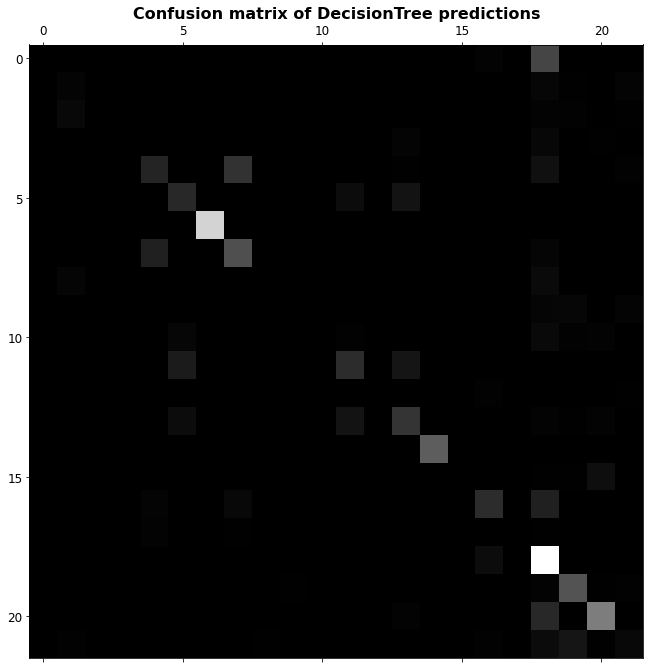

In [161]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.title("Confusion matrix of DecisionTree predictions", weight='bold', size = '16')

plt.show()

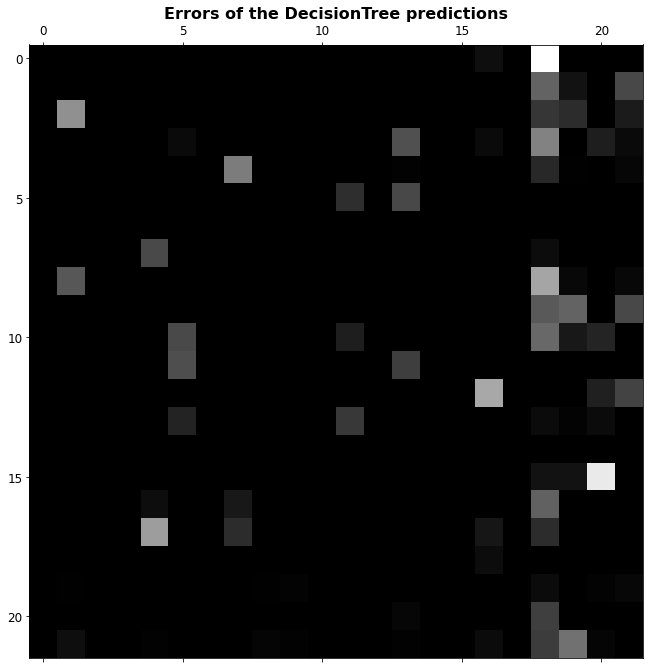

In [162]:
# we fill the diagonal with zeros to plot the errors

sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Errors of the DecisionTree predictions", weight="bold", size=16)
plt.show()

In [164]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

prec_score = precision_score(y_test_tree, y_pred_tree, average="weighted", zero_division=0)
rec_score = recall_score(y_test_tree, y_pred_tree, average="weighted", zero_division=0)
F1_score = f1_score(y_test_tree, y_pred_tree, average="weighted", zero_division=0)
acc_score = accuracy_score(y_test_tree, y_pred_tree)

print(f'The accuracy of the model is {acc_score}.')
print(f'The precision of the model is {prec_score}, using weighted average.')
print(f'The recall of the model is {rec_score}, using weighted average.')
print(f'The f1-score of the model is {F1_score}, using weighted average.')

The accuracy of the model is 0.6479709666776642.
The precision of the model is 0.5912871179400107, using weighted average.
The recall of the model is 0.6479709666776642, using weighted average.
The f1-score of the model is 0.6053623399249618, using weighted average.


In [178]:
dF_result = X_test_tree.copy()
df_result['predicted_next_event'] = y_pred_tree

# df_result['event concept:name'] = event_encoder.inverse_transform(df_result['event concept:name'])
df_result['predicted_next_event'] = event_encoder.inverse_transform(df_result['predicted_next_event'])

df_result.head()

,case AMOUNT_REQ,event concept:name,time of day,predicted_next_event
20348,5000,6,4611.000,A_DECLINED
20349,14000,9,4616.000,A_PARTLYSUBMITTED
20350,14000,6,4617.000,A_PREACCEPTED
20353,14000,7,4636.000,W_Completeren aanvraag
20356,15000,21,4653.000,W_Nabellen offertes


In [172]:
df_encodedTime = df_processed.copy()

In [173]:
df_encodedTime["Completion Time"] = np.nan
df_encodedTime["Completion Time"] = (df_encodedTime["nextTIME"] - df_encodedTime["event time:timestamp"]).apply(secondsTransform)
df_encodedTime.dropna(inplace=True)

df_encodedTime["Time Average"] = 0

for name, group in df_encodedTime[["event concept:name", "Completion Time"]].groupby(["event concept:name"]):
    mean = group["Completion Time"].mean()
    df_encodedTime.loc[df_encodedTime["event concept:name"] == name, "Time Average"] = mean

In [174]:
X = df_encodedTime[['event concept:name', "case AMOUNT_REQ", "Time Average"]]
y = df_encodedTime['Completion Time']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)
# % of negative predicted values
(len(y_pred[y_pred<0])/len(y_pred))*100

40.6421816582362

In [175]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 32747.905833780154
Mean Squared Error: 5259962474.567384
Root Mean Squared Error: 72525.59875359447
